# Student Teacher Network layers

## Checking Avilable GPU

In [1]:
!nvidia-smi

Tue Mar 28 19:25:51 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.05    Driver Version: 525.85.05    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   50C    P8    37W / 350W |    218MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [2]:
# systems libs
import os
import sys

# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
    import torchmetrics
except:
    !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

## device agnostic code

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Getting Dataset with pytorch

### Download Tiny ImageNet dataset

In [4]:
from pathlib import Path
data_path = Path('data')
data_path.mkdir(parents=True, exist_ok=True)
if not (data_path/'tiny-imagenet-200.zip').is_file():
    print("[INFO] Downloading Tiny ImageNet dataset...")
    !wget -O "data/tiny-imagenet-200.zip" "http://cs231n.stanford.edu/tiny-imagenet-200.zip"
    print("[INFO] Downloaded Tiny ImageNet dataset...")
if not (data_path/'tiny-imagenet-200').is_dir():
    print("[INFO] Unzipping Tiny ImageNet dataset...")
    !unzip -q -d {data_path} {data_path/'tiny-imagenet-200.zip'}

### prepare data for pytoch ImageFolder

In [5]:
import glob
import os
from shutil import move
from os import rmdir

target_folder = 'data/tiny-imagenet-200/val/'

val_dict = {}
try:
    with open(target_folder + 'val_annotations.txt', 'r') as f:
        for line in f.readlines():
            split_line = line.split('\t')
            val_dict[split_line[0]] = split_line[1]
            
    paths = glob.glob(target_folder + 'images/*')
    paths[0].split('/')[-1]
    for path in paths:
        file = path.split('/')[-1]
        folder = val_dict[file]
        if not os.path.exists(target_folder + str(folder)):
            os.mkdir(target_folder + str(folder))
            
    for path in paths:
        file = path.split('/')[-1]
        folder = val_dict[file]
        dest = target_folder + str(folder) + '/' + str(file)
        move(path, dest)
        
    os.remove('data/tiny-imagenet-200/val/val_annotations.txt')
    rmdir('data/tiny-imagenet-200/val/images')
    move('data/tiny-imagenet-200/val', 'data/tiny-imagenet-200/test')
except:
    print("[INFO] val folder already removed")
finally:
    print("[INFO] preprocessing done !!!")

[INFO] val folder already removed
[INFO] preprocessing done !!!


### Creating pytorch dataset

In [6]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
from pathlib import Path

train_dir = Path('data/tiny-imagenet-200/train')
test_dir = Path('data/tiny-imagenet-200/test/val/')

# tranform to apply to data resizes image to 224x224 and converts to tensor
data_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
])

train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform# transforms to perform on data (images)
                                  ) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform, # transforms to perform on data (images)
                                )
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")
print(f"Total classes: {len(train_data.classes)}")

Train data:
Dataset ImageFolder
    Number of datapoints: 100000
    Root location: data/tiny-imagenet-200/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 10000
    Root location: data/tiny-imagenet-200/test/val
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )
Total classes: 200


### Vis. dataset (train dataset)

In [7]:
# randomly ploting image samples from the grayscale dataset
def visualization(dataset):
  labels_map = dataset.class_to_idx # getting class -> index map
  labels_map = dict(map(reversed, labels_map.items())) # inverting dictionary
  figure = plt.figure(figsize=(8, 8)) # fixing plotsize
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(dataset), size=(1,)) # randomely selecting one image sample from the image index
      # print(sample_idx)
      # print(dataset[sample_idx])
      img, label = dataset[sample_idx.item()] # getting image and label of selected index
      # print(img.shape)
      # sub plot code
      figure.add_subplot(rows, cols, i) 
      plt.title(labels_map[label])
      plt.axis("off")
      plt.imshow(img.permute(1,2,0)) # NOTE:- Color map is gray because we're converting imgae to grayscale / permute is used to change the channel order
      # sub plot code ends
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


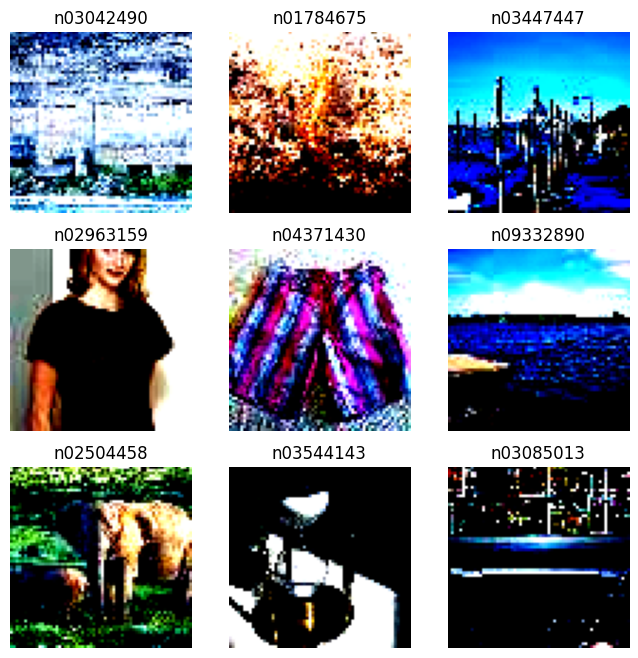

In [8]:
visualization(test_data)

### Conveting datasets to dataloders

In [9]:
# creating train and test dataloaders
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True, num_workers=os.cpu_count(),pin_memory = True) 
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=128, shuffle=False, num_workers=os.cpu_count(),pin_memory = True)

print(f"Train dataloader:\n{train_dataloader}\nTest dataloader:\n{test_dataloader}")
print(f"Train dataloader length: {len(train_dataloader)}\nTest dataloader length: {len(test_dataloader)}")

Train dataloader:
Test dataloader:
Train dataloader length: 782
Test dataloader length: 79


## Defining Student Teacher Models

### Teacher Network Defination

In [10]:
class TeacherNetwork(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int,
      num_filters:int,
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the dataset
      num_filters: number of filters in the conv layer
    '''
    super().__init__()
    conv_layers_list = [
      nn.Conv2d(
            in_channels = in_channels,
            out_channels = num_filters,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        ),
      nn.ReLU(),
    ]
    for _ in range(10):
      conv_layers_list.append(
        nn.Conv2d(
            in_channels = num_filters,
            out_channels = num_filters,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        )
      )
      conv_layers_list.append(nn.ReLU())
    
    conv_layers_list.append(
      nn.Conv2d(
            in_channels = num_filters,
            out_channels = hidden_units,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        )
    )
    conv_layers_list.append(nn.ReLU())
    
    # Defining the feature extraction layers of the neural network
    self.features = nn.Sequential(
      *conv_layers_list,
      nn.AvgPool2d(kernel_size=2, stride=2),
    )
    
    # Defining the classifier layers of the neural network
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 32 * 32,out_features=out_channels),
    )
    
    # intializing the weights of the neural network using xavier uniform initialization
    for _ in self.features:
      if type(_) != nn.modules.activation.ReLU and type(_) != nn.modules.pooling.AvgPool2d:
        # print(_,type(_))
        torch.nn.init.xavier_uniform_(_.weight)

    # intializing the weights of the neural network using xavier uniform initialization
    for _ in self.classifier:
      if type(_) != nn.modules.activation.ReLU and type(_) != nn.modules.flatten.Flatten:
        # print(_,type(_))
        torch.nn.init.xavier_uniform_(_.weight)
  def forward(self, x):
    # print("x.shape: ", x.shape)
    x = self.features(x)
    # print("x.shape: ", x.shape)
    x = self.classifier(x)
    # print("x.shape: ", x.shape)
    return x

### Student Network Defination

In [11]:
class StudentNetwork(nn.Module):
  def __init__(
      self,
      in_channels:int,
      hidden_units:int,
      out_channels:int,
      num_filters:int,
      ) -> None:
    '''
    args:
      in_channels: input image shape
      hidden_units: number of hidden in neural net.
      out_channels: number of classes in the dataset
      num_filters: number of filters in the conv layer
    '''
    super().__init__()
    conv_layers_list = [
      nn.Conv2d(
            in_channels = in_channels,
            out_channels = num_filters,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        ),
      nn.ReLU(),
    ]
    
    for _ in range(2):
      conv_layers_list.append(
        nn.Conv2d(
            in_channels = num_filters,
            out_channels = num_filters,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        )
      )
      conv_layers_list.append(nn.ReLU())
    
    conv_layers_list.append(
      nn.Conv2d(
            in_channels = num_filters,
            out_channels = hidden_units,
            kernel_size = 3,
            padding = 1,
            stride = 1,
        ),
    )
    conv_layers_list.append(nn.ReLU())
    
    # Defining the feature extraction layers of the neural network
    self.features = nn.Sequential(
      *conv_layers_list,
      nn.AvgPool2d(kernel_size=2, stride=2),
    )
    
    # Defining the classifier layers of the neural network
    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(in_features=hidden_units * 32 * 32,out_features=out_channels),
    )
    
    # intializing the weights of the neural network using xavier uniform initialization
    for _ in self.features:
      if type(_) != nn.modules.activation.ReLU and type(_) != nn.modules.pooling.AvgPool2d:
        # print(_,type(_))
        torch.nn.init.xavier_uniform_(_.weight)

    # intializing the weights of the neural network using xavier uniform initialization
    for _ in self.classifier:
      if type(_) != nn.modules.activation.ReLU and type(_) != nn.modules.flatten.Flatten:
        # print(_,type(_))
        torch.nn.init.xavier_uniform_(_.weight)

  def forward(self, x):
    # print("x.shape: ", x.shape)
    x = self.features(x)
    # print("x.shape: ", x.shape)
    x = self.classifier(x)
    # print("x.shape: ", x.shape)
    return x

## Model summaries

In [12]:
from torchinfo import summary
summary(
        model=TeacherNetwork(3,512,200,12),
        input_size=(32,3,64,64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
TeacherNetwork (TeacherNetwork)          [32, 3, 64, 64]      [32, 200]            --                   True
├─Sequential (features)                  [32, 3, 64, 64]      [32, 512, 32, 32]    --                   True
│    └─Conv2d (0)                        [32, 3, 64, 64]      [32, 12, 64, 64]     336                  True
│    └─ReLU (1)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (2)                        [32, 12, 64, 64]     [32, 12, 64, 64]     1,308                True
│    └─ReLU (3)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (4)                        [32, 12, 64, 64]     [32, 12, 64, 64]     1,308                True
│    └─ReLU (5)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (6)   

In [13]:
from torchinfo import summary
summary(
        model=StudentNetwork(3,512,200,12),
        input_size=(32,3,64,64),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
StudentNetwork (StudentNetwork)          [32, 3, 64, 64]      [32, 200]            --                   True
├─Sequential (features)                  [32, 3, 64, 64]      [32, 512, 32, 32]    --                   True
│    └─Conv2d (0)                        [32, 3, 64, 64]      [32, 12, 64, 64]     336                  True
│    └─ReLU (1)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (2)                        [32, 12, 64, 64]     [32, 12, 64, 64]     1,308                True
│    └─ReLU (3)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (4)                        [32, 12, 64, 64]     [32, 12, 64, 64]     1,308                True
│    └─ReLU (5)                          [32, 12, 64, 64]     [32, 12, 64, 64]     --                   --
│    └─Conv2d (6)   

## Training Models

### Plot loss curves of a model

In [14]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### train step

In [15]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    train_using_teacher: bool = False,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      train_teacher (bool): flag to train teacher model
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    # print(type(model.parameters()))
    for (X, y) in dataloader:  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        
        # 2. calculate the loss
        if train_using_teacher == True:
          # loss for student network
          global teacher_model
          teacher_model.eval()
          with torch.inference_mode():
            teacher_model.to(device)
            y_pred_logits_teacher = teacher_model(X)
          
          # Calculating the loss
          loss = loss_fn(y_pred_logits, y) + 0.5 * (y_pred_logits_teacher - y_pred_logits).pow(2).mean()
          
        else:
          loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()

        # 6. calculate the accuracy
        train_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)

#### test step

In [16]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [17]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    train_using_teacher: bool = False,
    save_model_name: str = "model.pt",
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      train_using_teacher (bool): flag to train teacher model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            train_using_teacher = train_using_teacher,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

        # 5. saving the model
        if (epoch + 1) > 5 and test_acc > best_test_acc:
          torch.save(model.state_dict(), save_model_name)
          best_test_acc = test_acc
    # 6. return result dict
    return result_dict

## Training Teacher Network

In [24]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# final parms
lr = [1e-3] # learning rate
# betas=[(0.8, 0.888)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)


parms_combs = [(l,w_d) for l in lr for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.001 weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.4577 | train_acc: 0.0044 | test_loss: 5.2985 | test_acc: 0.0049
Epoch: 2 | train_loss: 5.2193 | train_acc: 0.0119 | test_loss: 5.0788 | test_acc: 0.0191
Epoch: 3 | train_loss: 4.9849 | train_acc: 0.0340 | test_loss: 4.9415 | test_acc: 0.0364
Epoch: 4 | train_loss: 4.7792 | train_acc: 0.0541 | test_loss: 4.6905 | test_acc: 0.0609
Epoch: 5 | train_loss: 4.5576 | train_acc: 0.0782 | test_loss: 4.5666 | test_acc: 0.0789
Epoch: 6 | train_loss: 4.3434 | train_acc: 0.1027 | test_loss: 4.3668 | test_acc: 0.0979
Epoch: 7 | train_loss: 4.1528 | train_acc: 0.1271 | test_loss: 4.3235 | test_acc: 0.1015
Epoch: 8 | train_loss: 3.9833 | train_acc: 0.1495 | test_loss: 4.3003 | test_acc: 0.1057
Epoch: 9 | train_loss: 3.8314 | train_acc: 0.1716 | test_loss: 4.3341 | test_acc: 0.1008
Epoch: 10 | train_loss: 3.6759 | train_acc: 0.1958 | test_loss: 4.5230 | test_acc: 0.0833
Epoch: 11 | train_loss: 3.5145 | train_acc: 0.2210 | test_loss: 4.5394 | test_acc: 0.0958
Epoch: 12 | train_l

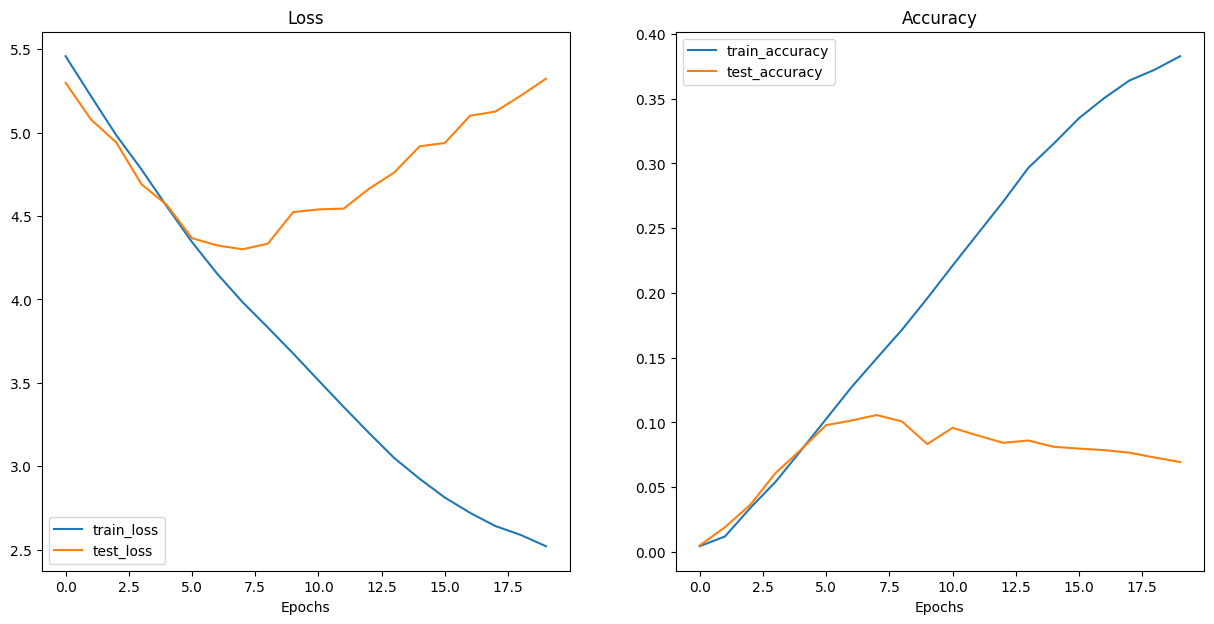

In [25]:
from torchvision.models import resnet18,ResNet18_Weights
cur,total = 1, len(lr)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_teacher = TeacherNetwork(in_channels=3,hidden_units=512,out_channels=200,num_filters=12).to(device)
  ### INIT MODEL END ###
    # init. optimizer
  optimizer = torch.optim.Adam(
      params=model_teacher.parameters(), lr=h_parms[0], weight_decay=h_parms[1]
  )

  # optimizer = torch.optim.SGD(
  #   params=model_teacher.parameters(), lr=h_parms[0], momentum=0.9, weight_decay=h_parms[1]
  # )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]} weight_decay: {h_parms[1]}")
  # train model
  model_teacher_results = train(
      model=model_teacher,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      train_using_teacher = False,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, weight_decay: {h_parms[1]}")
  plot_loss_curves(model_teacher_results)
  cur+=1
  del model_teacher
  print()

## Loading Trained Teacher Model

In [20]:
teacher_model = TeacherNetwork(in_channels=3,hidden_units=512,out_channels=200,num_filters=12).to(device)
teacher_model.load_state_dict(torch.load("model_6.pth"))
teacher_model.eval()

TeacherNetwork(
  (features): Sequential(
    (0): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU()
    (18): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (19): ReLU()
    (20): Conv2d(12, 12, kernel_size=(3

## Training Student Model without distillation

In [21]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# final parms
lr = [1e-3] # learning rate
# betas=[(0.8, 0.888)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)


parms_combs = [(l,w_d) for l in lr for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.001 weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.9394 | train_acc: 0.0584 | test_loss: 4.4956 | test_acc: 0.0988
Epoch: 2 | train_loss: 4.3078 | train_acc: 0.1227 | test_loss: 4.3097 | test_acc: 0.1189
Epoch: 3 | train_loss: 4.0142 | train_acc: 0.1618 | test_loss: 4.1115 | test_acc: 0.1448
Epoch: 4 | train_loss: 3.6696 | train_acc: 0.2136 | test_loss: 4.0726 | test_acc: 0.1465
Epoch: 5 | train_loss: 3.3168 | train_acc: 0.2709 | test_loss: 4.1338 | test_acc: 0.1447
Epoch: 6 | train_loss: 2.9151 | train_acc: 0.3401 | test_loss: 4.2569 | test_acc: 0.1358
Epoch: 7 | train_loss: 2.4687 | train_acc: 0.4216 | test_loss: 4.5147 | test_acc: 0.1271
Epoch: 8 | train_loss: 1.9886 | train_acc: 0.5153 | test_loss: 4.7962 | test_acc: 0.1175
Epoch: 9 | train_loss: 1.5844 | train_acc: 0.5992 | test_loss: 5.2662 | test_acc: 0.1030
Epoch: 10 | train_loss: 1.3094 | train_acc: 0.6592 | test_loss: 5.9152 | test_acc: 0.0986
Epoch: 11 | train_loss: 1.1010 | train_acc: 0.7091 | test_loss: 6.3321 | test_acc: 0.0962
Epoch: 12 | train_l

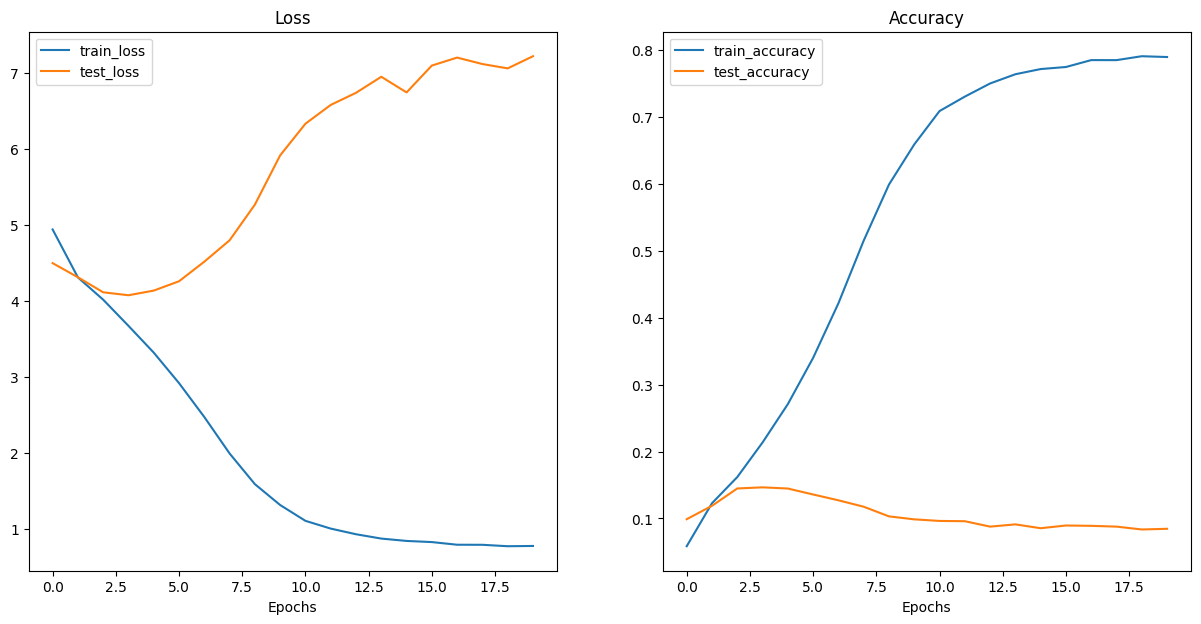

In [26]:
cur,total = 1, len(lr)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_student_only = StudentNetwork(in_channels=3,hidden_units=512,out_channels=200,num_filters=12).to(device)
  ### INIT MODEL END ###
    # init. optimizer
  optimizer = torch.optim.Adam(
      params=model_student_only.parameters(), lr=h_parms[0], weight_decay=h_parms[1]
  )

  # optimizer = torch.optim.SGD(
  #   params=model_student_only.parameters(), lr=h_parms[0], momentum=0.9, weight_decay=h_parms[1]
  # )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]} weight_decay: {h_parms[1]}")
  # train model
  model_student_only_results = train(
      model=model_student_only,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_model_name=f"model_student_only_lr_{h_parms[0]}_wd_{h_parms[1]}.pth",
      train_using_teacher=False,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, weight_decay: {h_parms[1]}")
  plot_loss_curves(model_student_only_results)
  cur+=1
  del model_student_only
  print()

## Training Student Model with distillation

In [21]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# final parms
lr = [1e-3] # learning rate
# betas=[(0.8, 0.888)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)


parms_combs = [(l,w_d) for l in lr for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.001 weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.9196 | train_acc: 0.0956 | test_loss: 4.1366 | test_acc: 0.1429
Epoch: 2 | train_loss: 4.5557 | train_acc: 0.1868 | test_loss: 3.9629 | test_acc: 0.1698
Epoch: 3 | train_loss: 4.2980 | train_acc: 0.2263 | test_loss: 3.9235 | test_acc: 0.1709
Epoch: 4 | train_loss: 4.1375 | train_acc: 0.2578 | test_loss: 3.8932 | test_acc: 0.1772
Epoch: 5 | train_loss: 3.9855 | train_acc: 0.2892 | test_loss: 3.8642 | test_acc: 0.1838
Epoch: 6 | train_loss: 3.8283 | train_acc: 0.3230 | test_loss: 3.8439 | test_acc: 0.1837
Epoch: 7 | train_loss: 3.6546 | train_acc: 0.3677 | test_loss: 4.0592 | test_acc: 0.1516
Epoch: 8 | train_loss: 3.4654 | train_acc: 0.4206 | test_loss: 3.9136 | test_acc: 0.1809
Epoch: 9 | train_loss: 3.2606 | train_acc: 0.4780 | test_loss: 3.9438 | test_acc: 0.1722
Epoch: 10 | train_loss: 3.0701 | train_acc: 0.5336 | test_loss: 3.9981 | test_acc: 0.1638
Epoch: 11 | train_loss: 2.9146 | train_acc: 0.5795 | test_loss: 3.9929 | test_acc: 0.1634
Epoch: 12 | train_l

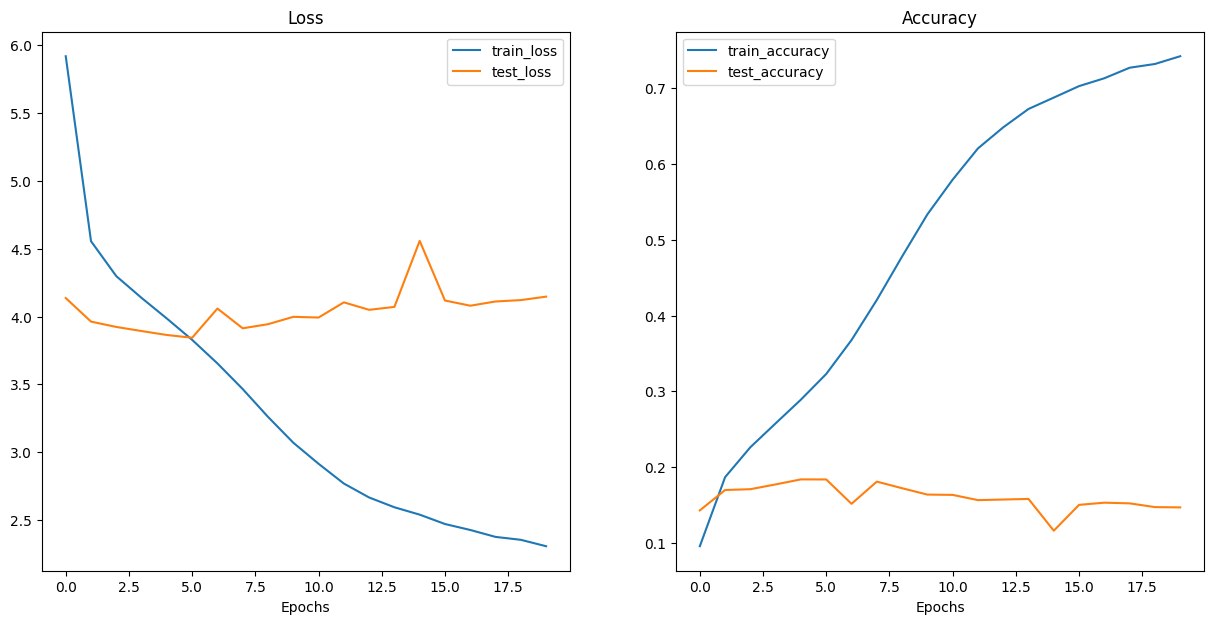

In [22]:

cur,total = 1, len(lr)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_student_only = StudentNetwork(in_channels=3,hidden_units=512,out_channels=200,num_filters=12).to(device)
  ### INIT MODEL END ###
    # init. optimizer
  optimizer = torch.optim.Adam(
      params=model_student_only.parameters(), lr=h_parms[0], weight_decay=h_parms[1]
  )

  # optimizer = torch.optim.SGD(
  #   params=model_student_only.parameters(), lr=h_parms[0], momentum=0.9, weight_decay=h_parms[1]
  # )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]} weight_decay: {h_parms[1]}")
  # train model
  model_student_only_results = train(
      model=model_student_only,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_model_name=f"model_student_teacher_lr_{h_parms[0]}_wd_{h_parms[1]}.pth",
      train_using_teacher=True,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, weight_decay: {h_parms[1]}")
  plot_loss_curves(model_student_only_results)
  cur+=1
  del model_student_only
  print()

## Training Student Model with distillation and EMA

In [21]:
def training_step_with_ema(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    train_using_teacher: bool = False,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      train_teacher (bool): flag to train teacher model
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch
    # print(type(model.parameters()))
    for epoch,(X, y) in enumerate(dataloader):  # loop in batches
        # model_parms_before_forward_pass = np.array([x.detach().numpy() for x in model.parameters()].copy())
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        
        # 2. calculate the loss
        if train_using_teacher == True:
          # loss for student network
          global teacher_model
          teacher_model.eval()
          with torch.inference_mode():
            teacher_model.to(device)
            y_pred_logits_teacher = teacher_model(X)
          
          # Calculating the loss
          loss = loss_fn(y_pred_logits, y) + 0.5 * (y_pred_logits_teacher - y_pred_logits).pow(2).mean()
          
        else:
          loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        # 6. calculate the accuracy
        train_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)
  
def testing_step_with_ema(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)
  
from tqdm.auto import tqdm


def train_with_ema(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    train_using_teacher: bool = False,
    save_model_name: str = "model.pt",
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      train_using_teacher (bool): flag to train teacher model
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    best_state_dict = None
    global ema_start,ema_model,ema_scheduler,scheduler
    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step_with_ema(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            train_using_teacher = train_using_teacher,
        )
        if epoch > ema_start:
          ema_model.update_parameters(model)
          ema_scheduler.step()
        else:
          scheduler.step()
        torch.optim.swa_utils.update_bn(train_dataloader, ema_model)
        

        test_loss, test_acc = testing_step_with_ema(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)

        # 5. saving the model
        if (epoch + 1) > 5 and test_acc > best_test_acc:
          best_state_dict = model.state_dict()
          best_test_acc = test_acc
    torch.save(model.state_dict(), save_model_name)
    # 6. return result dict
    return result_dict

In [22]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# final parms
lr = [1e-3] # learning rate
# betas=[(0.8, 0.888)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)


parms_combs = [(l,w_d) for l in lr for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 20

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=200).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.001 weight_decay: 0.001


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 5.9794 | train_acc: 0.0904 | test_loss: 4.2062 | test_acc: 0.1339
Epoch: 2 | train_loss: 4.6961 | train_acc: 0.1747 | test_loss: 4.0200 | test_acc: 0.1569
Epoch: 3 | train_loss: 4.4171 | train_acc: 0.2100 | test_loss: 3.9425 | test_acc: 0.1699
Epoch: 4 | train_loss: 4.2506 | train_acc: 0.2352 | test_loss: 3.9168 | test_acc: 0.1734
Epoch: 5 | train_loss: 4.1162 | train_acc: 0.2619 | test_loss: 3.9041 | test_acc: 0.1739
Epoch: 6 | train_loss: 3.9824 | train_acc: 0.2889 | test_loss: 3.9221 | test_acc: 0.1682
Epoch: 7 | train_loss: 3.8359 | train_acc: 0.3237 | test_loss: 3.9000 | test_acc: 0.1751
Epoch: 8 | train_loss: 3.6758 | train_acc: 0.3655 | test_loss: 3.9460 | test_acc: 0.1674
Epoch: 9 | train_loss: 3.5148 | train_acc: 0.4093 | test_loss: 3.9180 | test_acc: 0.1698
Epoch: 10 | train_loss: 3.3525 | train_acc: 0.4549 | test_loss: 3.9777 | test_acc: 0.1697
Epoch: 11 | train_loss: 3.1984 | train_acc: 0.5016 | test_loss: 3.9938 | test_acc: 0.1660
Epoch: 12 | train_l

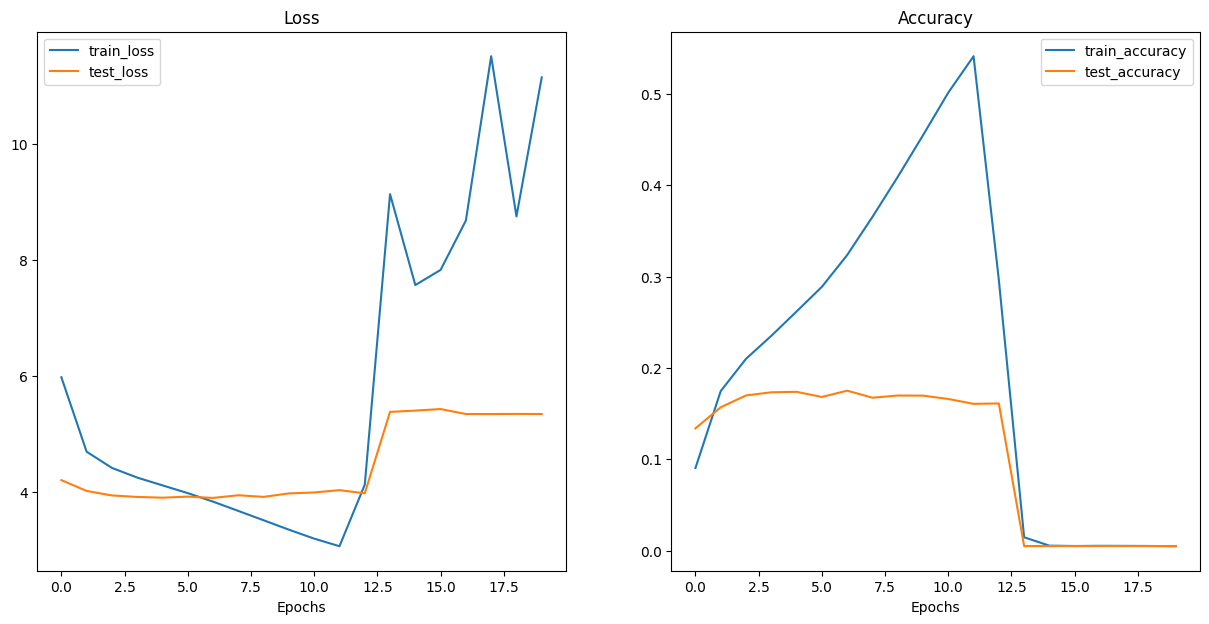

In [23]:
from torch.optim.swa_utils import SWALR

cur,total = 1, len(lr)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_student_only = StudentNetwork(in_channels=3,hidden_units=512,out_channels=200,num_filters=12).to(device)
  ### INIT MODEL END ###
    # init. optimizer
  optimizer = torch.optim.Adam(
      params=model_student_only.parameters(), lr=h_parms[0], weight_decay=h_parms[1]
  )
  ema_avg = lambda averaged_model_parameter, model_parameter, num_averaged: 0.1 * averaged_model_parameter + 0.9 * model_parameter
  ema_model = torch.optim.swa_utils.AveragedModel(model_student_only, avg_fn=ema_avg)
  scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
  ema_start = 10
  ema_scheduler = SWALR(optimizer, swa_lr=0.05)

  # optimizer = torch.optim.SGD(
  #   params=model_student_only.parameters(), lr=h_parms[0], momentum=0.9, weight_decay=h_parms[1]
  # )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]} weight_decay: {h_parms[1]}")
  # train model
  model_student_only_results = train_with_ema(
      model=model_student_only,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_model_name=f"model_student_teacher_lr_{h_parms[0]}_wd_{h_parms[1]}_with_ema.pth",
      train_using_teacher=True,
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, weight_decay: {h_parms[1]}")
  plot_loss_curves(model_student_only_results)
  cur+=1
  del model_student_only
  print()